In [1]:
import pandas as pd
df_train = pd.read_csv("/kaggle/input/hallym-ai-text-classification/train.csv")
df_train

,id,text,label
0,0,한림봉사단(봉사단)의 본격적인 활동이 시작됐다. 첫 번째 활동인 '사랑의 집수리'가...,0
1,1,몇 년 전 김난도 교수의 '아프니까 청춘이다'라는 책이 대학생들 사이에서 큰 공감과...,0
2,2,점심시간이 되면 배고픈 학생들보다 빠르게 교내 식당으로 달려가는 이들이 있다. 바로...,0
3,3,우리 대학을 설립한 고(故) 윤덕선 박사의 제29주기 추도식이 거행됐다. 지난 12...,0
4,4,2019년 4월 1일 일본의 새로운 연호가 발표됐다. 나루히토 친왕의 연호는 '레이...,0
...,...,...,...
1495,1495,지난 9일 우리 대학 레크리에이션센터 실내체육관에서는 2018 한림대학교 전공페어가...,0
1496,1496,올해로 우리 대학의 LINC 사업단이 프로그램 운영 1년차를 맞았다. 본지에서는 재...,0
1497,1497,작년에 우리 학교는 정부가 실시하는 구조개혁평가에서 A 등급을 받아 지금까지도 캠퍼...,0
1498,1498,2014학년도 입학식이 지난 3일 한림스포츠센터 실내체육관에서 열렸다. 노건일 총장...,0


In [2]:
# 1. 기본 라이브러리
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.model_selection import train_test_split
import copy
from tqdm import tqdm

# GPU 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 2. 데이터 로드
# df_train 은 이미 로드되어 있다고 가정합니다.

# 3. label 0과 1에서 각각 250개씩 샘플링
sampled_0 = df_train[df_train['label'] == 0].sample(n=250, random_state=42)
sampled_1 = df_train[df_train['label'] == 1].sample(n=250, random_state=42)
df_sampled = pd.concat([sampled_0, sampled_1]).reset_index(drop=True)

# 4. 8:1:1 비율로 train, val, test 나누기 (계층적 샘플링 유지)
df_train_split, df_temp = train_test_split(
    df_sampled,
    test_size=0.2,
    stratify=df_sampled['label'],
    random_state=42
)
df_val_split, df_test_split = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp['label'],
    random_state=42
)

print(f"Train size: {len(df_train_split)}")
print(f"Validation size: {len(df_val_split)}")
print(f"Test size: {len(df_test_split)}")

# 5. 토크나이저 설정
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
MAX_LEN = 512
BATCH_SIZE = 32

# 6. Dataset 클래스 정의
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 7. Dataset 및 DataLoader 생성
train_dataset = TextDataset(
    texts=df_train_split['text'].tolist(),
    labels=df_train_split['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
val_dataset = TextDataset(
    texts=df_val_split['text'].tolist(),
    labels=df_val_split['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = TextDataset(
    texts=df_test_split['text'].tolist(),
    labels=df_test_split['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 8. LSTM 분류기 정의
class LSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=1, freeze_bert=True):
        super(LSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("klue/bert-base")
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_out, _ = self.lstm(sequence_output)
        final_hidden_state = lstm_out[:, -1, :]
        logits = self.fc(final_hidden_state)
        return self.sigmoid(logits).squeeze()

# 9. 모델 초기화, 손실, 옵티마이저, 스케줄러 세팅
model = LSTMClassifier(freeze_bert=False).to(device)
criterion = nn.BCELoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, weight_decay=0.01)
scheduler = MultiStepLR(optimizer, milestones=[10, 20], gamma=0.5)

# 10. 평가 함수
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    preds, labels_all = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].float().to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds += (outputs > 0.5).cpu().tolist()
            labels_all += labels.cpu().tolist()
    accuracy = accuracy_score(labels_all, preds)
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

# 11. 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0
best_model_state = None
early_stop_counter = 0
early_stop_patience = 3

for epoch in range(30):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/30")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    val_loss, val_acc = evaluate(model, val_loader)

    scheduler.step()

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}")
    print(f"           Val   Loss={val_loss:.4f}, Val   Acc={val_acc:.4f}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.10f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
        print("✅ Best model updated!")
    else:
        early_stop_counter += 1
        print(f"⚠️ Validation accuracy did not improve. ({early_stop_counter}/{early_stop_patience})")
        if early_stop_counter >= early_stop_patience:
            print("🛑 Early stopping triggered.")
            break


2025-05-22 12:41:34.879160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747917695.081487      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747917695.140220      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda
Train size: 400
Validation size: 50
Test size: 50


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Epoch 1/30: 100%|██████████| 13/13 [00:40<00:00,  3.09s/it, loss=0.67] 



Epoch 1: Train Loss=0.6838, Train Acc=0.5450
           Val   Loss=0.6690, Val   Acc=0.6200
Current LR: 0.0000200000
✅ Best model updated!


Epoch 2/30: 100%|██████████| 13/13 [00:43<00:00,  3.36s/it, loss=0.603]



Epoch 2: Train Loss=0.6162, Train Acc=0.7825
           Val   Loss=0.6231, Val   Acc=0.7000
Current LR: 0.0000200000
✅ Best model updated!


Epoch 3/30: 100%|██████████| 13/13 [00:48<00:00,  3.71s/it, loss=0.391]



Epoch 3: Train Loss=0.4950, Train Acc=0.8350
           Val   Loss=0.4236, Val   Acc=0.8600
Current LR: 0.0000200000
✅ Best model updated!


Epoch 4/30: 100%|██████████| 13/13 [00:46<00:00,  3.55s/it, loss=0.104]



Epoch 4: Train Loss=0.2182, Train Acc=0.9675
           Val   Loss=0.0867, Val   Acc=1.0000
Current LR: 0.0000200000
✅ Best model updated!


Epoch 5/30: 100%|██████████| 13/13 [00:47<00:00,  3.63s/it, loss=0.0414]



Epoch 5: Train Loss=0.0718, Train Acc=0.9925
           Val   Loss=0.0452, Val   Acc=0.9800
Current LR: 0.0000200000
⚠️ Validation accuracy did not improve. (1/3)


Epoch 6/30: 100%|██████████| 13/13 [00:46<00:00,  3.61s/it, loss=0.0227]



Epoch 6: Train Loss=0.0297, Train Acc=1.0000
           Val   Loss=0.0276, Val   Acc=1.0000
Current LR: 0.0000200000
⚠️ Validation accuracy did not improve. (2/3)


Epoch 7/30: 100%|██████████| 13/13 [00:47<00:00,  3.62s/it, loss=0.0173]



Epoch 7: Train Loss=0.0196, Train Acc=1.0000
           Val   Loss=0.0159, Val   Acc=1.0000
Current LR: 0.0000200000
⚠️ Validation accuracy did not improve. (3/3)
🛑 Early stopping triggered.


# 새 섹션

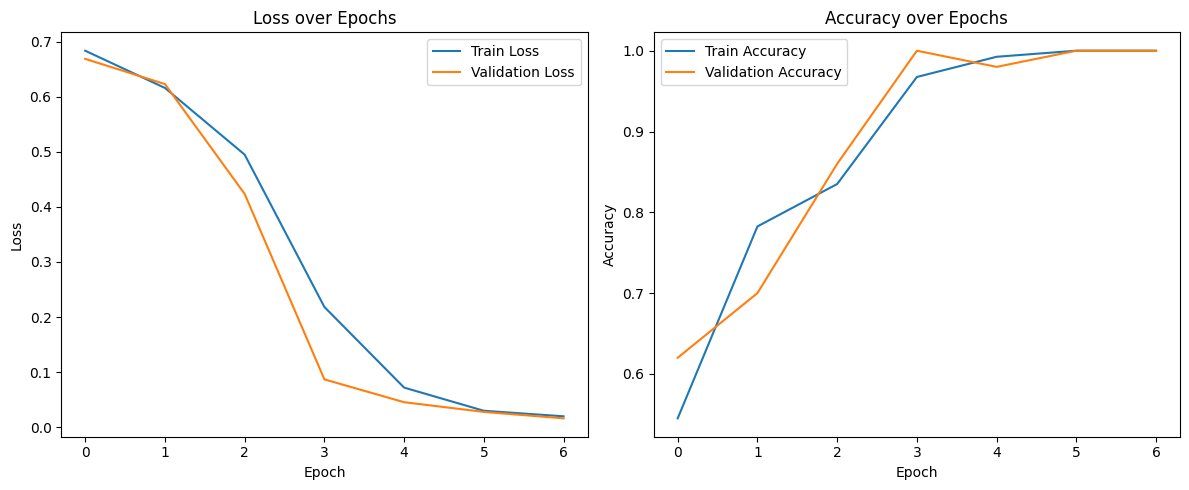

In [3]:
import matplotlib.pyplot as plt

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
# 11. 평가 함수
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].to(device)

            output = model(input_ids, attention_mask)
            preds += (output > 0.5).cpu().tolist()
            labels += label.cpu().tolist()
    acc = accuracy_score(labels, preds)
    print("Accuracy:", acc)
    print(classification_report(labels, preds))

In [5]:
from sklearn.metrics import classification_report

In [6]:
# 12. 검증 및 테스트 평가
print("\n📌 Validation Set Evaluation")
evaluate(model, val_loader)

print("\n📌 Test Set Evaluation")
evaluate(model, test_loader)


📌 Validation Set Evaluation
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50


📌 Test Set Evaluation
Accuracy: 0.98
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [7]:
# test.csv는 id와 text 열을 가지고 있다고 가정
real_test = pd.read_csv('/kaggle/input/hallym-ai-text-classification/test.csv')
real_test.head()

,id,text
0,0,"지난 2월, 아들을 군에 보낸 후 빈 방을 바라보며 허전함을 달래기 위해 해군교육사..."
1,1,본교 한림과학원장 김용구 교수가 제16회 용재상을 수상했다. 이는 연세대 초대 총장...
2,2,우리 대학 학생식당에 대한 학생들의 만족도가 2013년 11월에 실시한 조사 결과보...
3,3,"매년 기숙사 생활을 이어왔지만, 2017년 2학기에는 처음으로 외국인 기숙사인 HI..."
4,4,"지난 2006년 6월, 삼성의 청탁을 받은 금창태 시사저널 사장이 비밀리에 인쇄소에..."


In [8]:
from torch.utils.data import Dataset, DataLoader

class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }

# NaN 또는 빈칸 제거 (필요 시)
real_test = real_test.dropna(subset=['text'])
real_test = real_test[real_test['text'].str.strip().astype(bool)].reset_index(drop=True)

# Dataset & DataLoader 생성
inference_dataset = InferenceDataset(real_test['text'].tolist(), tokenizer, MAX_LEN)
inference_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE)


In [9]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in inference_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = (outputs > 0.5).long().cpu().tolist()
        predictions.extend(preds)

# 예측 결과를 데이터프레임에 저장
real_test['predicted_label'] = predictions


In [10]:
real_test[['text', 'predicted_label']].head()

,text,predicted_label
0,"지난 2월, 아들을 군에 보낸 후 빈 방을 바라보며 허전함을 달래기 위해 해군교육사...",1
1,본교 한림과학원장 김용구 교수가 제16회 용재상을 수상했다. 이는 연세대 초대 총장...,0
2,우리 대학 학생식당에 대한 학생들의 만족도가 2013년 11월에 실시한 조사 결과보...,1
3,"매년 기숙사 생활을 이어왔지만, 2017년 2학기에는 처음으로 외국인 기숙사인 HI...",1
4,"지난 2006년 6월, 삼성의 청탁을 받은 금창태 시사저널 사장이 비밀리에 인쇄소에...",0


In [11]:
real_test['predicted_label'].value_counts() # 1이 166개

predicted_label
0    391
1    109
Name: count, dtype: int64

In [14]:
real_test.to_csv('submission.csv', index=False, encoding='utf-8-sig')

In [13]:
real_test

,id,text,predicted_label
0,0,"지난 2월, 아들을 군에 보낸 후 빈 방을 바라보며 허전함을 달래기 위해 해군교육사...",1
1,1,본교 한림과학원장 김용구 교수가 제16회 용재상을 수상했다. 이는 연세대 초대 총장...,0
2,2,우리 대학 학생식당에 대한 학생들의 만족도가 2013년 11월에 실시한 조사 결과보...,1
3,3,"매년 기숙사 생활을 이어왔지만, 2017년 2학기에는 처음으로 외국인 기숙사인 HI...",1
4,4,"지난 2006년 6월, 삼성의 청탁을 받은 금창태 시사저널 사장이 비밀리에 인쇄소에...",0
...,...,...,...
495,495,지난 1일 교육과학기술부(교과부)가 재정지원 제한 대학(부실대학)을 발표했다. 부실...,0
496,496,강원도 광역치매센터 개소 10주년을 기념하고 관심을 촉구하는 치매극복의 날 행사가 ...,0
497,497,"'기업분석 창의제안 경진대회', 기업을 보는 시각을 키우다! 2013년 1학기를 마...",1
498,498,"지난 6일 우리대학 '한림봉사단', '해비타트', '글로벌프랜즈'가 무주택자에게 집...",0


In [15]:
real_test = real_test.drop(columns=['text'])
real_test = real_test.rename(columns={'predicted_label': 'label'})
real_test

,id,label
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
495,495,0
496,496,0
497,497,1
498,498,0


In [17]:
real_test.to_csv('submission.csv', index=False, encoding='utf-8-sig')

In [18]:
df2 = pd.read_csv('/kaggle/working/submission.csv')

In [19]:
df2

,id,label
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
495,495,0
496,496,0
497,497,1
498,498,0
